1. Introduction

2. Load and check data
- load data
- outlier detection
- joining train and test set
- check for null and missing values

3. Feature analysis
- Numerical values
- Categorical values

4. Filling missing values
- Age
- cabin?

5. Feature engineering
- name/title
- family size
- cavin
- ticket

6. Modeling
- Simple modeling
  - Cross validate models
  - hyperparamater tunning for best models
  plot learning curves
  Feature importance of the tree vased classifiers

- Ensemble modeling
  - Combining mocels

- Prediction
  -Predict and submit results



#Load data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=2.5, style='white', context='notebook', palette='deep')
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve






##2. Load and check data

2-1. Load data

In [ ]:
# train=pd.read_csv('../input/train.csv')
# test=pd.read_csv('../input/test.csv)
# IDtest=test['PassengerId']



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


data='/content/drive/MyDrive/주피터_대피소/kaggle&github/1.titanic/'
train=pd.read_csv(data+'train.csv')
test=pd.read_csv(data+'test.csv')

IDtest=test['PassengerId']




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: ignored

0

2-2. Outlier detection

In [ ]:
def detect_outliers(df, n, features) :
  ###detect_outliers(df,features,n) 이 순서로 했으면 덜 헷갈렸을듯
  '''
  Takes a dataframe df of features and returns a list of the indices
  corresponding to the observations containing more than n outliers 
  according to the Tukey method.
  '''

  outlier_indices =[]

  #iterate over features(columns)
  for col in features :
    Q1=np.percentile(df[col],25)
    Q3=np.percentile(df[col],75)
    IQR=Q3-Q1

    #outlier step
    outlier_step=1.5*IQR

    #Determine a list of incides of outliers for feature col
    outlier_list_col = df[ (df[col] < Q1 - outlier_step) | (df[col] >Q3 + outlier_step)].index

    #append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

    #select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

#detect outliers from Age, SibSp, Parch and Fare

Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

Since outliers can have a dramatic effect on the prediction (esp for regression problems), i choosed to manage them.

I used the Tukey method(1997) to detect outliers which defines an interquartile range comprised btw the 1st and 3rd quartile of the distribution values. An outlier is a row that have a feature values outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features(Age, SibSp, Parch and Fare). Then, i considered outliers as rows that have at leat two outlied numerical values.



In [ ]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [ ]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

2-3. joining train and test set

In [ ]:
# join train and test datasets in order to obtain the same number of features during categorical conversion

train_len = len(train)
dataset= pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

I Join train and test datasets to obtain the same number of features during categorical conversion

2-4. check for null and missing values

In [ ]:
# fill empty and NaNs values with NaN

dataset = dataset.fillna(np.nan)

#check for null values

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Survived missing values correspond to the join testing dataset (Survived column doesn't exist in testset and has been replaced by NaN values when concatenating the train and test set)

In [ ]:
#Infos

train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
### Summerize data
# Summerize and statistics

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


we can assume that survived is nomial, Pclass,SibSp,Parch are nomial or ordinal, Fare is  ratio scale.

so, survived convert to categorical type,
others convert to same.



#3. Feature Analysis

3-1. Numerical values

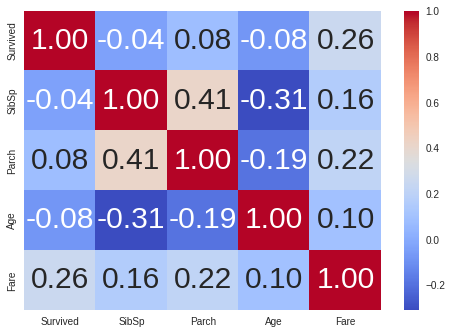

In [ ]:
# correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g= sns.heatmap(train[ ['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt='.2f', cmap='coolwarm')

SibSp

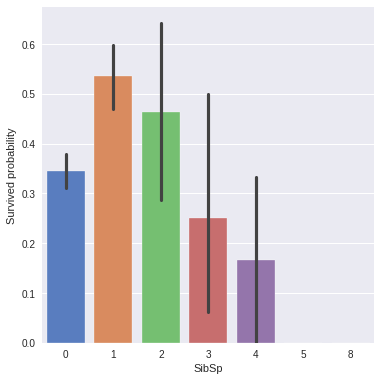

In [ ]:
g=sns.factorplot(x='SibSp',y='Survived',data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survived probability')

Parch

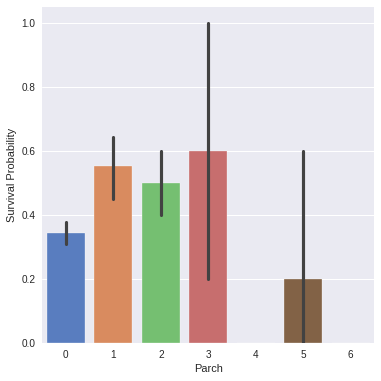

In [ ]:
# Explore parch feature vs Survived

g=sns.factorplot('Parch','Survived',data=train, kind='bar', size=6, palette ='muted')
g.despine(left=True)
g=g.set_ylabels('Survival Probability')

Age

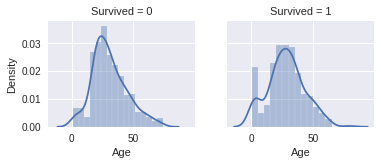

In [ ]:
g=sns.FacetGrid(train, col='Survived')
g=g.map(sns.distplot, 'Age')

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers bw 60 to 80 have less survived.

So, even if 'Age'is not correlated with 'Survived', we can see that there is age categoes of passenger s that of have more or less chance to survivee.

It seems that very young passengers have more chance to survive.

We use kde(kerenel density estimator)plot.

this plot makes distributions of histogram for curve.

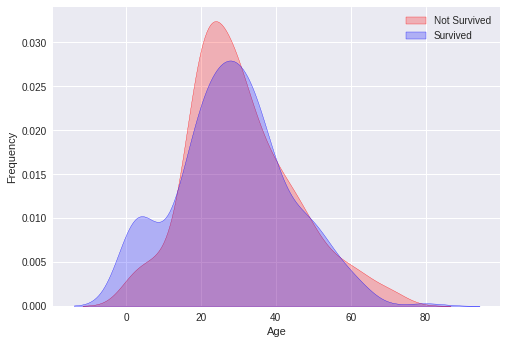

In [ ]:
#Explore Age distribution

g=sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade = True)

g=sns.kdeplot( train['Age'][ (train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue',shade=True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')

g=g.legend(['Not Survived','Survived'])

When we superimpose the two densities, we cleary see a peak corresponsing(between 0 and 5) to babies and very young childrens.

Fare

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
#fill fare missing values with the median value

dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

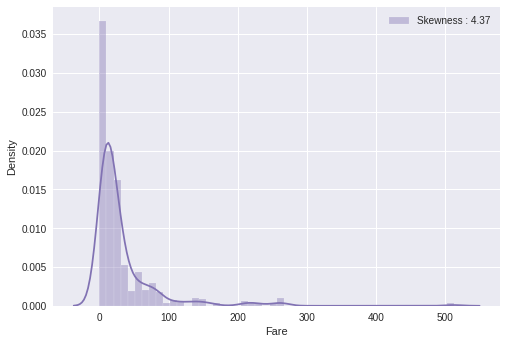

In [ ]:
#Explore Fare distribution

g=sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g=g.legend(loc='best')

As we can see, Fare distribution is very skewed. This can lead to overweight very high values in the mode, even if it is scaled.

In this case, it is veeter to tansform it with the log function to reduce this skew.

In [ ]:
#Apply log to Fare to reduce skewness distriution

dataset['Fare']=dataset['Fare'].map(lambda i : np.log(i) if i >0 else 0)

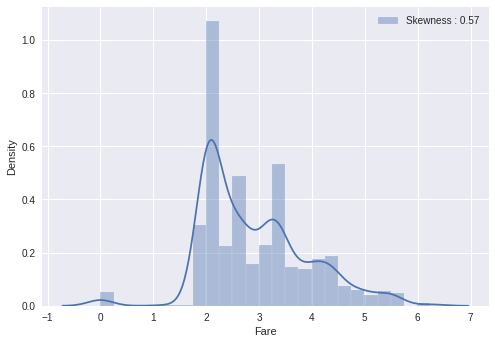

In [ ]:
g=sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f'%(dataset['Fare'].skew()))

g=g.legend(loc='best')

###3-2. Categorical values

Sex

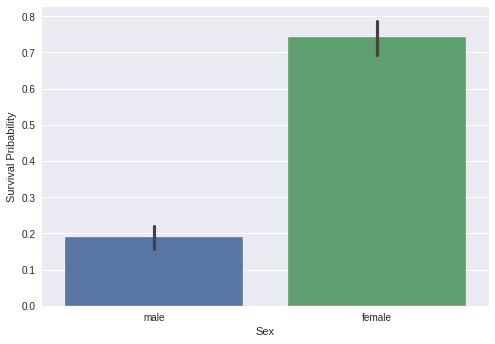

In [ ]:
g=sns.barplot('Sex','Survived',data=train)
g=g.set_ylabel('Survival Pribability')

In [ ]:
train[ ['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Pclass

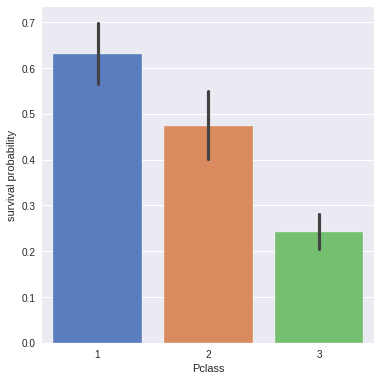

In [ ]:
g=sns.factorplot('Pclass','Survived',data=train, kind='bar',size=6, palette='muted')

g.despine(left=True)
g=g.set_ylabels('survival probability')

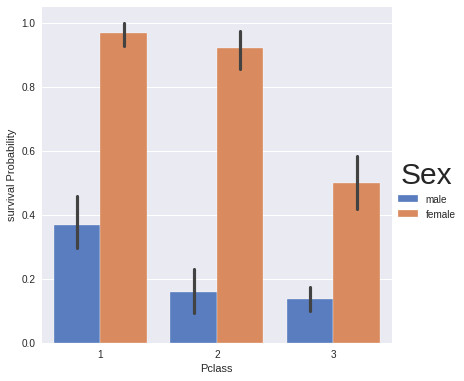

In [ ]:
g=sns.factorplot('Pclass','Survived',hue='Sex',data=train, size=6, kind='bar',palette='muted')

g.despine(left=True)
g=g.set_ylabels('survival Probability')

Embarked

In [ ]:
dataset['Embarked'].isnull().sum()

2

In [ ]:
dataset['Embarked']=dataset['Embarked'].fillna('S')

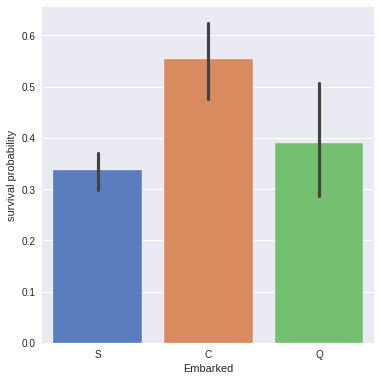

In [ ]:
g=sns.factorplot('Embarked','Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g=g.set_ylabels('survival probability')

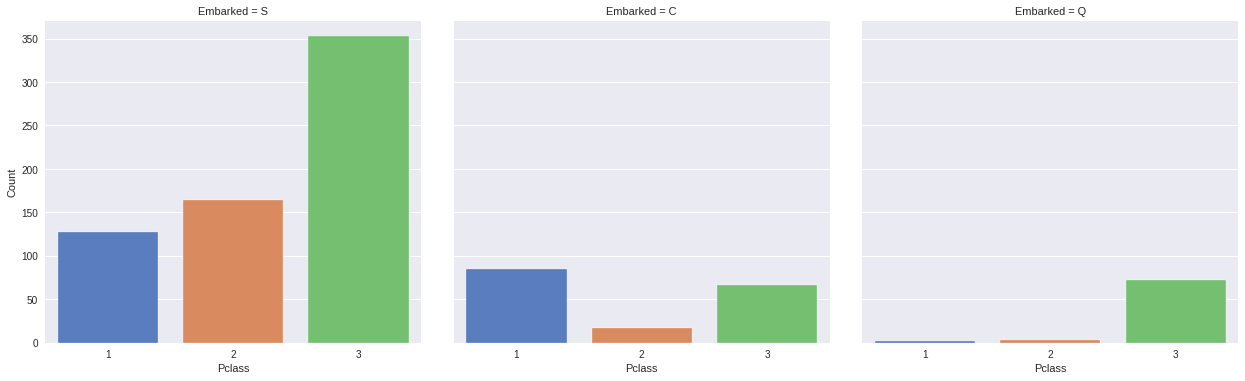

In [ ]:
g=sns.factorplot('Pclass',col='Embarked', data=train, size=6, kind='count',palette='muted')
g.despine(left=True)
g=g.set_ylabels('Count')

##4. Filling missing Values

4-1. Age

As we see, Age coulmn contains 256 missig balues in the while dataset.

Since there is subpopulations that have more chance to survive(children for example), it is preferable to keep the age feature and to impute the missing values

To adress this problem, i looked at the *most correlated features with Age* (Sex, Parch, Plcass and SibSp).

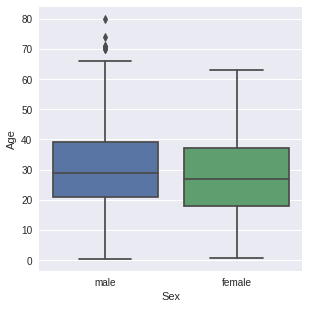

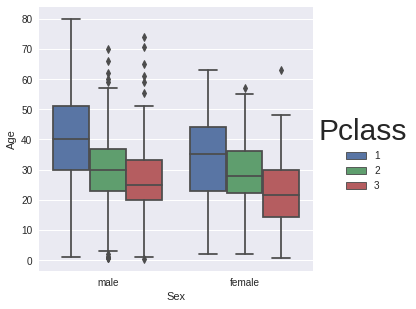

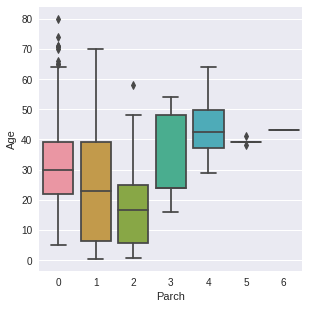

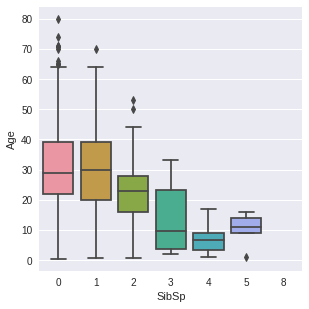

In [ ]:
# Explore Age vs Sex, Parch, SibSp, Pclass


g=sns.factorplot('Sex','Age', data=train, kind='box')
g=sns.factorplot('Sex','Age',hue='Pclass', data=train, kind='box')
g=sns.factorplot('Parch','Age',data=train, kind='box')
g=sns.factorplot('SibSp','Age',data=train, kind='box')

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1st class passengers are *older than 2nd class passengers *who are also *older than 3rd class passengers*.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [ ]:
dataset['Sex']=dataset['Sex'].map({'male':0, 'female':1})

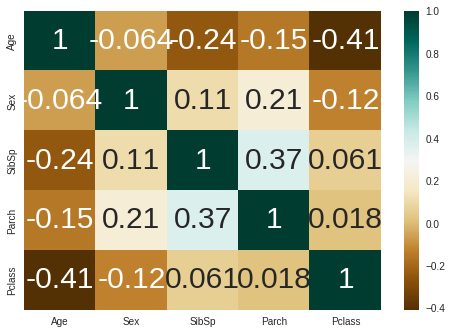

In [ ]:
g=sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),annot=True,cmap='BrBG')

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch, and SibSp.

In the plot of Age in function of PArch, AGe is growing with the number of parents / children. But the general correlation is negative.

So, i decided to use SibSp, Parch, Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according ro Pclass, Parch and SibSp.

In [ ]:
# Filling missing values of Age

## Fill age with the median age of similar rows according to Pclass, Parch and SibSp
#Index of nan age rows

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)


index_NaN_age
for i in index_NaN_age :
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][ ( (dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()

  if not np.isnan(age_pred) :
    dataset['Age'].iloc[i]=age_pred
  else :
    dataset['Age'].iloc[i]=age_med


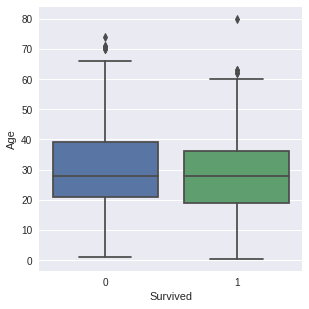

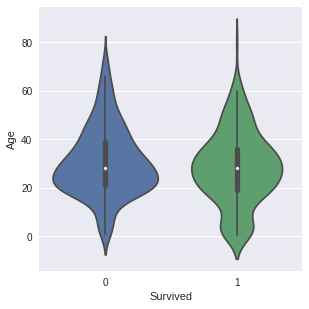

In [ ]:
g=sns.factorplot('Survived','Age',data=train, kind='box')
g=sns.factorplot('Survived','Age',data=train, kind='violin')

#5. Feature engineering

5-1. Name/Title

In [ ]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
# Get title from name

dataset_title=[i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]

dataset['Title']=pd.Series(dataset_title)
print(dataset['Title'].value_counts())


# or use str.extract
# dataset['Title1']=dataset['Name'].str.extract(r'([A-Za-z]+)\.')
# print(dataset['Title1'].value_counts())

# print('is same?', (dataset['Title'] == dataset['Title1']).all())

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64


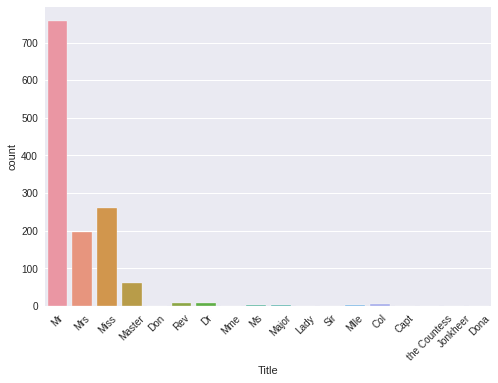

In [ ]:
g=sns.countplot(x='Title',data=dataset)
g=plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [ ]:
#Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

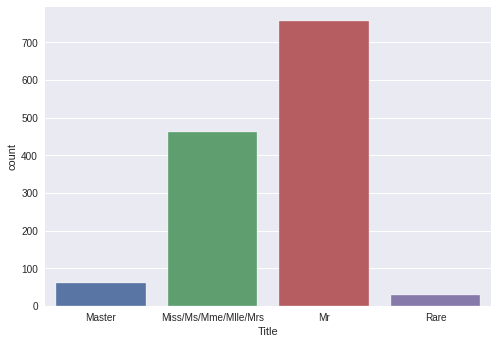

In [ ]:
g=sns.countplot(dataset['Title'])

g=g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

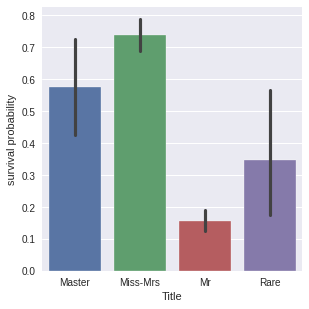

In [ ]:
g=sns.factorplot('Title','Survived',data=dataset, kind='bar')
g=g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g=g.set_ylabels('survival probability')

In [ ]:
#Drop Name variable

dataset.drop(labels= ['Name'], axis=1, inplace=True)

5-2. Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a 'Fize' feature which is the sum of SibSp, Parch and 1

In [ ]:
# Create a family size descriptor from SibSp and Parch

dataset['Fsize']=dataset['Parch']+dataset['SibSp'] +1

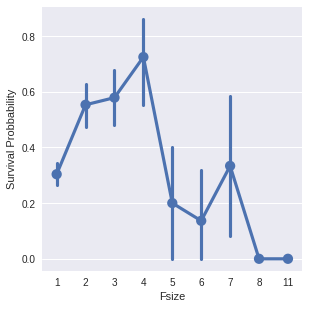

In [ ]:
g=sns.factorplot('Fsize','Survived',data=dataset)
g=g.set_ylabels('Survival Probbability')

In [ ]:
# Create new feature of family size

dataset['Single']=dataset['Fsize'].map(lambda s : 1 if s==1 else 0)
dataset['SmallF']=dataset['Fsize'].map(lambda s : 1 if s==2 else 0)
dataset['MedF']=dataset['Fsize'].map(lambda s : 1 if 3 <= s <= 4 else 0)
dataset['LargeF']=dataset['Fsize'].map(lambda s : 1 if 5 <= s else 0)

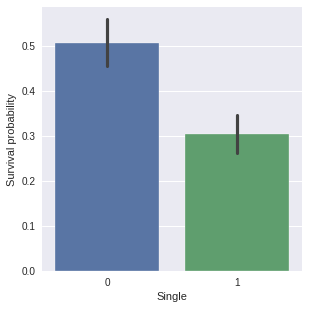

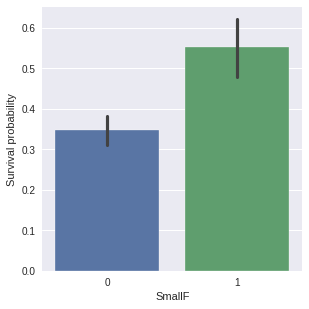

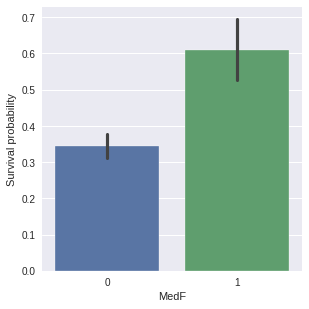

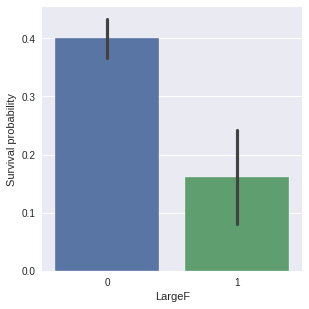

In [ ]:
g=sns.factorplot('Single','Survived', data=dataset, kind='bar')
g=g.set_ylabels('Survival probability')

g=sns.factorplot('SmallF','Survived',data=dataset, kind='bar')
g=g.set_ylabels('Survival probability')

g=sns.factorplot('MedF','Survived',data=dataset, kind='bar')
g=g.set_ylabels('Survival probability')

g=sns.factorplot('LargeF','Survived',data=dataset, kind='bar')
g=g.set_ylabels('Survival probability')

In [ ]:
# convert to indicator values Title and Embarked

dataset=pd.get_dummies(dataset, columns = ['Title'])
dataset=pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


5-3. Cabin

In [ ]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].isnull().sum()

1014

The Cabin feature column contains 295 values and 1014 missing values.

So, i supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [ ]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64

In [ ]:
# Replace the Cabin number by the type of cabin 'x' if not

dataset['Cabin']=pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

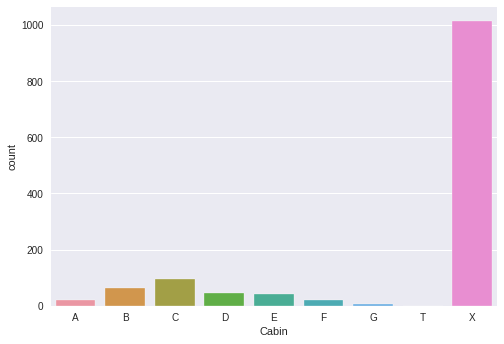

In [ ]:
g=sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

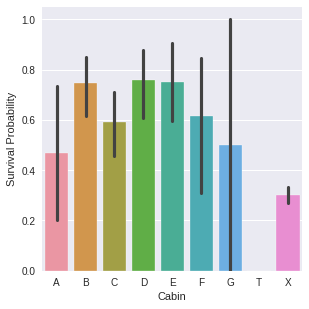

In [ ]:
g=sns.factorplot('Cabin','Survived', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g=g.set_ylabels('Survival Probability') 

Because of the low number of passenger that have a cabin, survival probabilities have an important standatd diviation and we can't distinguish between survival robability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (x)

It is particularly true for cabin B,C,D,E and F.

In [ ]:
dataset=pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


5-4. Ticket

In [ ]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [ ]:
dataset['Ticket'].value_counts()

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: Ticket, Length: 929, dtype: int64

It could mean that tickets sharing the same prefixs could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So i decided to replace the ticket feature coulumn by the ticket prefix. Which maybe more informative.

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix, it returns x.

Ticket =[]

for i in list(dataset.Ticket) :
  if not i.isdigit() :
    Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
  else :
    Ticket.append('X')

dataset['Ticket']= Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset['Ticket'].value_counts()

X          957
PC          92
CA          68
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
C            8
SOC          8
SOPP         7
STONO2       7
SCParis      5
SCAH         5
PP           4
LINE         4
WEP          4
FC           3
SOTONO2      3
SCA4         2
SWPP         2
PPP          2
SC           2
SCA3         1
A            1
LP           1
AQ4          1
STONOQ       1
Fa           1
CASOTON      1
AS           1
SCOW         1
SOP          1
SP           1
AQ3          1
Name: Ticket, dtype: int64

In [ ]:
dataset=pd.get_dummies(dataset,columns=['Ticket'],prefix='T')

In [ ]:
# create categorical values for Pclass

dataset['Pclass']= dataset['Pclass'].astype('category')

dataset=pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [ ]:
# Drop useless variables

dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


#6. modeling

In [ ]:
## Separate train dataset and test dataset


train=dataset[:train_len]
test=dataset[train_len:]
test.drop(labels=['Survived'],axis=1, inplace=True)

In [ ]:
## Seperate train features and label

train['Survived']= train['Survived'].astype(int)

Y_train = train['Survived']
X_train =train.drop(labels=['Survived'], axis=1)

6-1. Simple modeling

Cross validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold corss validation procedure.

- SVC
- Decision Tree
- AdaBoost
- RandomForest
- Extra Trees
- Gradient Boosting
- Multiple layer perceptron (NN)
- KNN
- Logistic regression
- Linear Discriminant Analysis

Linear Discriminant Analysis(LDA)

: 데이터 분포를 학습하여 결정경계(Decision boundary)를 만들어 데이터를 분류하는 모델

데이터를 특정 한 축에 대해 projection한 후 범주를 잘 구분하는 직선을 찾는 것.

직선의 기준 : projection후 두 범주의 평균의 거리는 max, variance는 min


m2-m1=wT(m2-m1) 일때,

mk=wTmk의 값이 max인 값을 찾아야하며,

분산이 다음과 같을경우,
s^2k=sig(yn-mk)^2
의 값이 최소화되어야한다.


OR 베이즈 룰을 사용한 구현

In [ ]:
# cross validate model with Kfold stratifies cross val

kfold = StratifiedKFold(n_splits=10)

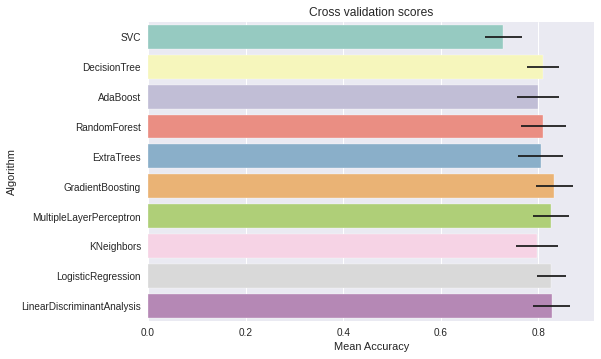

In [ ]:
# modeling step test differents algorithms

random_state=42
classifiers=[]
classifiers.append(SVC(random_state=random_state))

classifiers.append(DecisionTreeClassifier(random_state=random_state))

classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))

classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))

classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))

classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())


cv_results=[]

for classifier in classifiers : 
  cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv=kfold, n_jobs=4))


cv_means= []
cv_std = []

for cv_result in cv_results :
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())


cv_res=pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 'Algorithm':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting','MultipleLayerPerceptron','KNeighbors','LogisticRegression','LinearDiscriminantAnalysis']})

g=sns.barplot('CrossValMeans','Algorithm',data=cv_res, palette='Set3', orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g=g.set_title('Cross validation scores')





**6-2. hyperparamater tunning for best models**

n_jobs parameter to 4 since i have 4 cpu.

this step took 15min with 4cpu.

In [ ]:
## Meta modeling with adaboost, rf, extratrees and gradientboosting


#Adaboost

DTC=DecisionTreeClassifier()

adaDTC= AdaBoostClassifier(DTC, random_state=42)

ada_param_grid= {'base_estimator__criterion': ['gini','entropy'],
                 'base_estimator__splitter' : ['best','random'],
                 'algorithm' : ['SAMME','SAMME.R'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=True)

gsadaDTC.fit(X_train,Y_train)

ada_best=gsadaDTC.best_estimator_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


In [ ]:
gsadaDTC.best_score_

0.8149063670411983

In [ ]:
#ExtraTrees

ExtC=ExtraTreesClassifier()

## Search grid for optimal parameters

ex_param_grid={'max_depth':[None],
               'max_features':[1,3,10],
               'min_samples_split':[2,3,10],
               'min_samples_leaf':[1,3,10],
               'bootstrap':[False],
               'n_estimators':[100,300],
               'criterion':['gini']}

gsExtC=GridSearchCV(ExtC,param_grid=ex_param_grid, cv=kfold, scoring='accuracy',n_jobs=4, verbose=True)

gsExtC.fit(X_train,Y_train)

ExtC_best=gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8305368289637952

In [ ]:
## RFC Parameters Tunning

RFC=RandomForestClassifier()

#Search grid for optimal parameters

rf_param_grid={'max_depth':[None],
               'max_features':[1,3,10],
               'min_samples_split':[2,3,10],
               'min_samples_leaf':[1,3,10],
               'bootstrap':[False],
               'n_estimators':[100,300],
               'criterion':['gini']}
gsRFC=GridSearchCV(RFC,param_grid=rf_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=True)

gsRFC.fit(X_train,Y_train)

RFC_best=gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.838426966292135

In [ ]:
# Gradient boosting tunning


GBC=GradientBoostingClassifier()

gb_param_grid={'loss':['deviance'],
               'n_estimators':[100,200,300],
               'learning_rate':[0.1,0.2,0.3,1],
               'max_depth':[4,8],
               'min_samples_leaf':[100,150],
               'max_features':[0.3,0.1]}

gsGBC=GridSearchCV(GBC,param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsGBC.fit(X_train,Y_train)

GBC_best=gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


0.8440074906367041

In [ ]:
### SVC classifier

SVMC=SVC(probability=True)
svc_param_grid={'kernel':['rbf'],
                'gamma':[0.1,0.2,0.3,0.4,1],
                'C':[1,10,50,100,200]}

gsSVMC=GridSearchCV(SVMC,param_grid=svc_param_grid,cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsSVMC.fit(X_train,Y_train)

SVMC_best=gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


0.8249563046192261

6-3. plot learning curves

Learning Curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.



documentation


matplotlib.pyplot.fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)

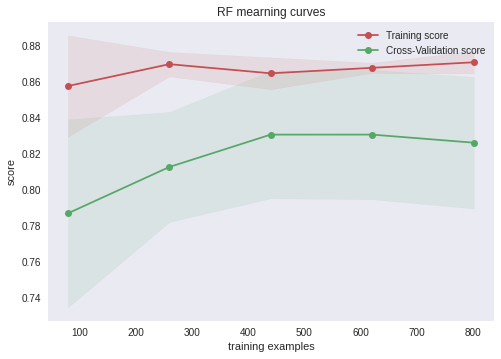

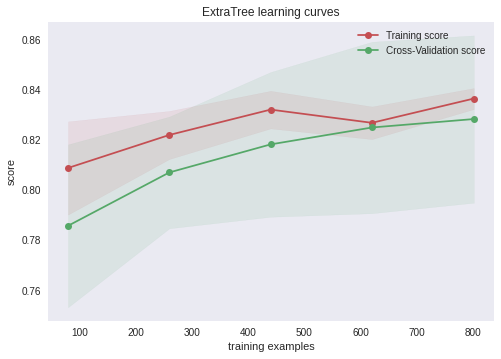

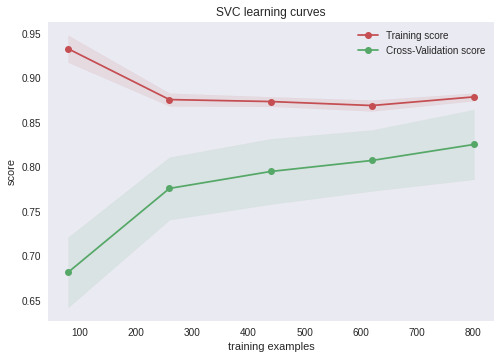

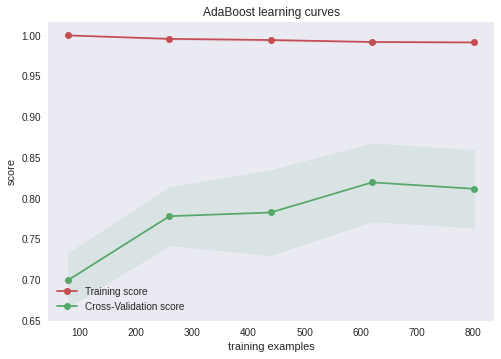

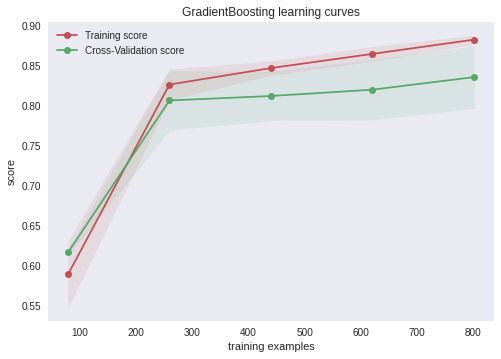

In [ ]:
def plot_learning_curve(estimator, title, X,y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1,1.0,5)) :

  """Generate a simple plot of the test and training learning curve"""
  plt.figure()
  plt.title(title)
  if ylim is not None :
    plt.ylim(*ylim)
  plt.xlabel('training examples')
  plt.ylabel('score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X,y, cv=cv, n_jobs=n_jobs, train_sizes = train_sizes)
  train_scores_mean=np.mean(train_scores, axis=1)
  train_scores_std=np.std(train_scores, axis=1)
  test_scores_mean=np.mean(test_scores, axis=1)
  test_scores_std=np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation score')

  plt.legend(loc='best')
  return plt

g=plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv=kfold)

g=plot_learning_curve(gsExtC.best_estimator_, 'ExtraTree learning curves',X_train,Y_train, cv=kfold)

g=plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves',X_train,Y_train, cv=kfold)

g=plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves',X_train,Y_train, cv=kfold)

g=plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves',X_train,Y_train, cv=kfold)

GradientBoost and AdaBoost classifiers tend to overfit the training set.

According to the growing cross-validation curves GradientBoosting and ADaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

**6-4. Feature importance of tree based classifiers**

Inorder to see the most informative features for the prediction of passengers survival, i displated the feature importance for the 4 tree based classifiers.

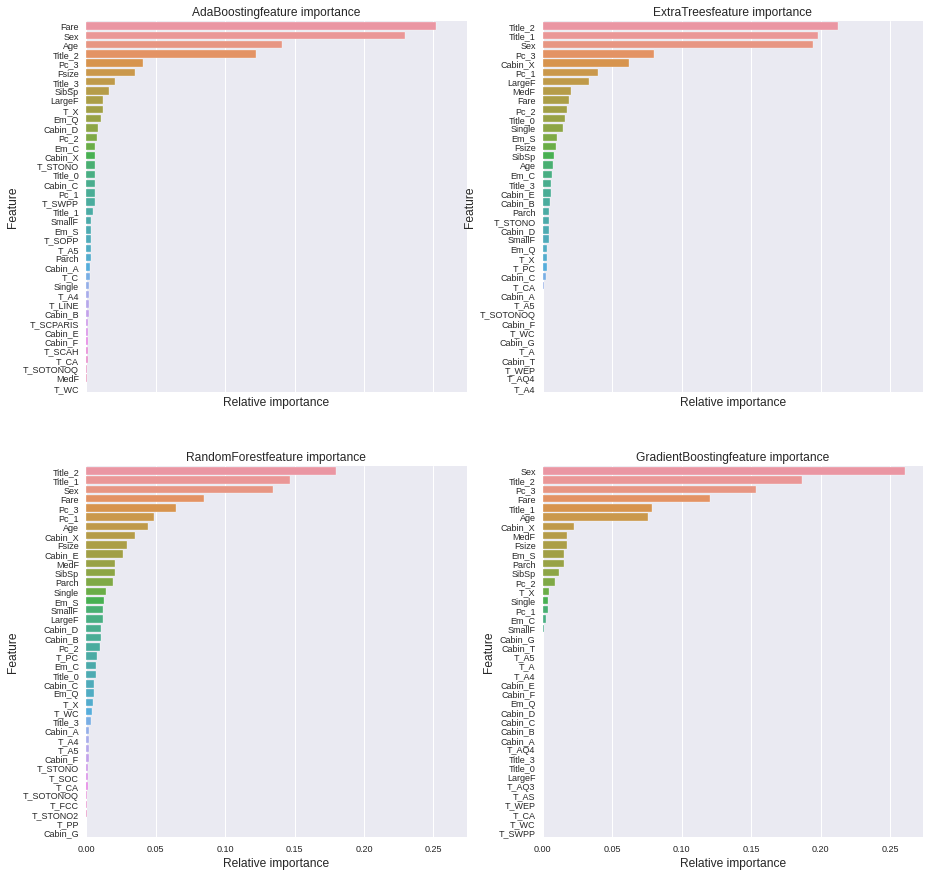

In [ ]:
nrows= ncols=2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers = [ ('AdaBoosting',ada_best), ('ExtraTrees',ExtC_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best)]


nclassifier=0

for row in range(nrows) :
  for col in range(ncols) :
    name=names_classifiers[nclassifier][0]
    classifier=names_classifiers[nclassifier][1]
    indices=np.argsort(classifier.feature_importances_)[::-1][:40]
    g=sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40], orient='h', ax=ax[row][col])
    g.set_xlabel('Relative importance',fontsize=12)
    g.set_ylabel('Feature',fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + 'feature importance')
    nclassifier +=1


i plot the feature importance for the ***4 tree ased classifers*** (AdaBoost, ExtraTree, RandomForest, GradientBoosting).

We note that the four classifers **have different top features** according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification, ex) 'Fare', 'Title_2','Age','Sex'.

We can say that :
- Pc_1, Pc_2, Pc_3 and FAre refer to the general social standing of passengers.
- SEx and Title_2 and Title_3 refer to the gender.
- Age and Title_1 refer to the age of passengers.
- Fsize, LargeF, MedF, Single refer to the size of the passenger family.


According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, sex, familysize and the social standing of the passengers more than the location in the boat.

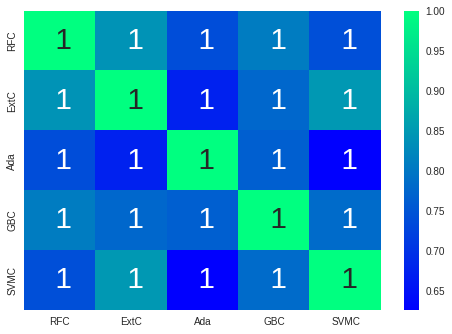

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test),name='ExtC')
test_Survived_SVMC=pd.Series(SVMC_best.predict(test),name='SVMC')
test_Survived_Ada=pd.Series(ada_best.predict(test),name='Ada')
test_Survived_GBC=pd.Series(GBC_best.predict(test),name='GBC')


#Concatenate all classifier results

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_Ada, test_Survived_GBC, test_Survived_SVMC],axis=1)


g=sns.heatmap(ensemble_results.corr(),annot=True, fmt='2.0f',cmap='winter')

6.2. Ensemble modeling

In [ ]:
votingC=VotingClassifier(estimators=[('rfc',RFC_best),('extc',ExtC_best),('svc',SVMC_best),('ada',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)


votingC=votingC.fit(X_train,Y_train)

SyntaxError: ignored

6.3 Prediction and Submit results

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

results=pd.concat([IDtest, test_Survived],axis=1)

results.to.csv('ensemble_python_voting.csv',index=False)